In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import minmax_scale, StandardScaler
import matplotlib
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils import data
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter

c:\Users\yair0\.conda\envs\Yairama\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Getting sample from 3D block as vertical drill hole

Text(0.5, 1.0, 'Drill holes - plan view')

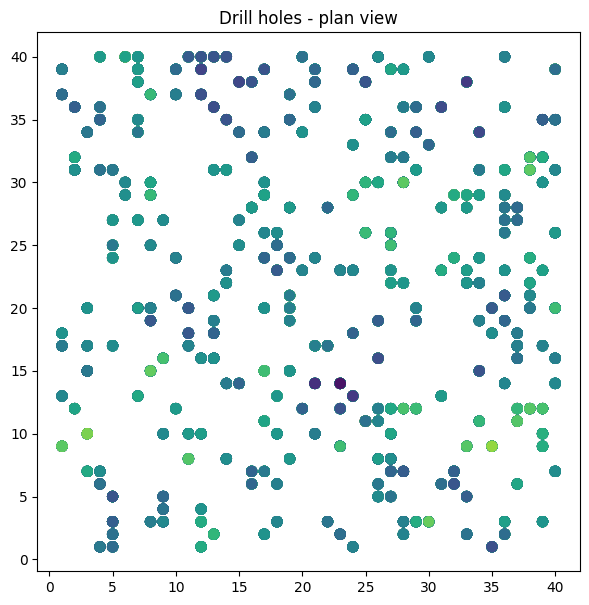

In [111]:
df_simulation = pd.read_csv('data/simulation_data.csv')

grid_size = max(df_simulation['x'].max(),df_simulation['y'].max(),df_simulation['y'].max())

numer_of_drillholes = 300

df_simulation[['x','y','z']] = df_simulation[['x','y','z']].astype(float)
x_y_grid = np.array(np.meshgrid(np.arange(1,grid_size+1,1), np.arange(1,grid_size+1,1))).T.reshape(-1,2)
df_simulation_sample = pd.DataFrame(columns=['x','y','z','finos'])
for item in np.random.default_rng().choice(x_y_grid,numer_of_drillholes):
    df_temp = df_simulation[(df_simulation['x']==item[0]) & (df_simulation['y']==item[1])]
    df_simulation_sample = pd.concat([df_temp, df_simulation_sample])



fig = plt.gcf()
fig.set_size_inches(7,7)
plt.scatter(df_simulation_sample['x'],df_simulation_sample['y'],
c=df_simulation_sample['finos'], marker='o', s=50)
plt.title('Drill holes - plan view')

### Adding some random points from the block

In [112]:
df_simulation_sample = pd.concat([df_simulation_sample, df_simulation.sample(600)])
df_simulation_sample.drop_duplicates(inplace=True)
df_simulation_sample

,x,y,z,finos,litho,alter
60000,38.0,21.0,1.0,3.335490,Litho_B,Alter_C
60001,38.0,21.0,2.0,2.701133,Litho_B,Alter_C
60002,38.0,21.0,3.0,2.981999,Litho_B,Alter_C
60003,38.0,21.0,4.0,3.231367,Litho_B,Alter_B
60004,38.0,21.0,5.0,3.415481,Litho_B,Alter_B
...,...,...,...,...,...,...
23277,15.0,22.0,38.0,4.628404,Litho_B,Alter_D
48160,31.0,5.0,1.0,1.946369,Litho_C,Alter_C
55956,35.0,39.0,37.0,3.925676,Litho_C,Alter_C
18194,12.0,15.0,35.0,4.719416,Litho_B,Alter_A


### Creating a Multilayer perceptron to make predictions

#### Create Training Dataset

In [113]:
df_sample = pd.get_dummies(df_simulation_sample)
columns = df_sample.columns.tolist()
columns.remove('finos')
columns.append('finos')
df_sample = df_sample[columns]

df = pd.get_dummies(df_simulation)
columns = df.columns.tolist()
columns.remove('finos')
columns.append('finos')
df = df[columns]

sc = StandardScaler()
sc.fit(df[['x','y','z']])
df[['x','y','z']] = sc.transform(df[['x','y','z']])
df_sample[['x','y','z']] = sc.transform(df_sample[['x','y','z']])

### Using Pytorch

In [114]:
# Define la clase de la red neuronal
class MineralPredictionNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(MineralPredictionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 27)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(27, 243)
        self.fc3 = nn.Linear(243, 729)
        self.fc4 = nn.Linear(729, output_size)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

class Data(torch.utils.data.Dataset):
  def __init__(self, X: pd.DataFrame, y: pd.DataFrame, device) -> None:
    # need to convert float64 to float32 else
    # will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X.to_numpy().astype(np.float32)).to(device)
    self.y = torch.from_numpy(y.to_numpy().astype(np.float32)).to(device)
    self.len = self.X.shape[0]
  def __getitem__(self, index: int) -> tuple:
    return self.X[index], self.y[index]
  def __len__(self) -> int:
    return self.len

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

train = Data(X_train, y_train,device)
val = Data(X_val, y_val,device)
real = Data(df.iloc[:,:-1],df.iloc[:,-1], device)

train_loader = data.DataLoader(train, batch_size=50)
val_loader = data.DataLoader(val, batch_size=50)
real_loader = data.DataLoader(real)

input_size = X.shape[1]  # 3 coordenadas XYZ y n_litologies litologías
hidden_size = 32
output_size = 1  # Ley mineral del yacimiento

# Inicializa la red neuronal
model = MineralPredictionNet(input_size, output_size)
model.to(device)

# Define la función de pérdida y el optimizador
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

writer = SummaryWriter()

In [116]:
# Repite el proceso de entrenamiento y validación varias veces
epochs = 4000
loss_list=[]
val_list = []
for epoch in range(epochs):
    # Itera a través de los datos de entrenamiento
    running_loss = 0
    running_val = 0
    for x, y in train_loader:
        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()
        loss = criterion(y_pred, y)

        # Realiza el backpropagation y actualiza los parámetros
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss = running_loss + loss.item()
    loss_list.append(running_loss)

    # Itera a través de los datos de validación
    for x,y in val_loader:
        # Convierte los datos a tensores de PyTorch

        # Predice la salida usando la red neuronal
        y_pred = model(x)
        y_pred = y_pred.squeeze()

        # Calcula la pérdida
        val = criterion(y_pred, y)
        running_val = running_val + val.item()
    val_list.append(running_val)

    writer.add_scalar("Loss/train", loss, epoch)
    writer.add_scalar("Validation/train", val, epoch)
    
      # display statistics
    print(f'epoch {epoch + 1}, loss {running_loss:f}')
    print(f'epoch {epoch + 1}, val {running_val:f}')

epoch 1, loss 199.361983
epoch 1, val 38.846223
epoch 2, loss 153.159534
epoch 2, val 37.766898
epoch 3, loss 150.850643
epoch 3, val 37.541519
epoch 4, loss 149.455959
epoch 4, val 37.310165
epoch 5, loss 149.728825
epoch 5, val 37.638120
epoch 6, loss 148.081090
epoch 6, val 36.755740
epoch 7, loss 147.049162
epoch 7, val 36.826074
epoch 8, loss 146.545064
epoch 8, val 36.681596
epoch 9, loss 145.561879
epoch 9, val 36.805941
epoch 10, loss 144.831939
epoch 10, val 36.346881
epoch 11, loss 144.352932
epoch 11, val 36.397253
epoch 12, loss 143.836052
epoch 12, val 35.897262
epoch 13, loss 142.962710
epoch 13, val 36.263528
epoch 14, loss 142.362989
epoch 14, val 36.036155
epoch 15, loss 141.775853
epoch 15, val 35.850290
epoch 16, loss 141.334995
epoch 16, val 35.898831
epoch 17, loss 140.268241
epoch 17, val 35.723554
epoch 18, loss 139.912406
epoch 18, val 35.724569
epoch 19, loss 139.962412
epoch 19, val 35.709115
epoch 20, loss 139.139209
epoch 20, val 36.416020
epoch 21, loss 138

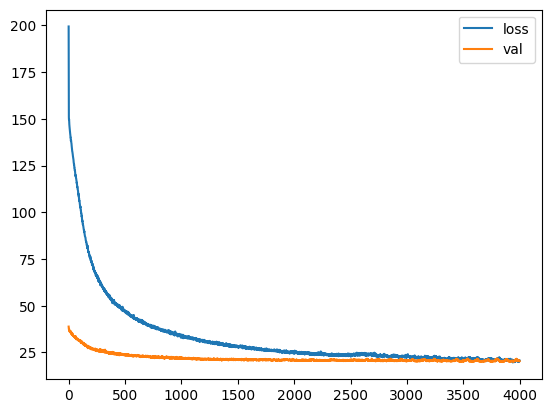

In [117]:
plt.plot(loss_list, label='loss')
plt.plot(val_list, label='val')
plt.legend()

r2:  0.38185882266403015
mae:  0.5692482212894246
mape:  128451759571.0876


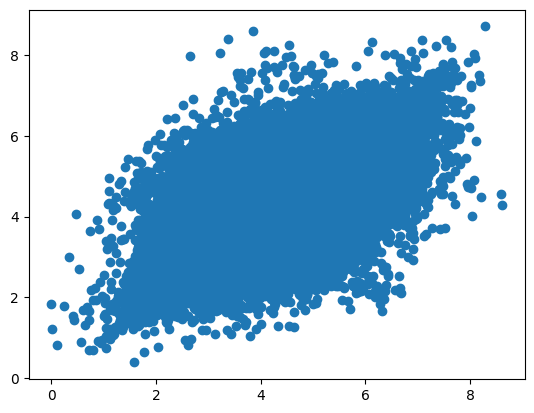

In [118]:
y_pred = []
y_real = []
for x,y in real_loader:
    y_p = model(x)
    y_pred.append(y_p.item())
    y_real.append(y.item())

print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

### Using Tensorflow

In [119]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Define el tamaño de entrada, oculto y salida de la red neuronal
X = df_sample.iloc[:,:-1]
y = df_sample.iloc[:,-1]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def build_model():
    input_layer = layers.Input(shape=(X_train.shape[1],), name='input')
    first_dense = layers.Dense(units=27, activation='relu')(input_layer)
    second_dense = layers.Dense(units=243, activation='relu')(first_dense)
    third_dense = layers.Dense(units=729, activation='relu')(second_dense)
    output = layers.Dense(units=1, name='out')(third_dense)

    return Model(inputs=input_layer, outputs=output)

model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=tf.keras.metrics.MeanAbsoluteError(),
              )
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10)]              0         
                                                                 
 dense_21 (Dense)            (None, 27)                297       
                                                                 
 dense_22 (Dense)            (None, 243)               6804      
                                                                 
 dense_23 (Dense)            (None, 729)               177876    
                                                                 
 out (Dense)                 (None, 1)                 730       
                                                                 
Total params: 185,707
Trainable params: 185,707
Non-trainable params: 0
_________________________________________________________________


In [120]:
# Train the model for 200 epochs
history = model.fit(X_train, y_train,
                    epochs=300, batch_size=50, validation_data=(X_val, y_val))

Epoch 1/300
183/183 [==============================] - 1s 5ms/step - loss: 1.0334 - mean_absolute_error: 1.0334 - val_loss: 0.8751 - val_mean_absolute_error: 0.8751
Epoch 2/300
183/183 [==============================] - 1s 3ms/step - loss: 0.8357 - mean_absolute_error: 0.8357 - val_loss: 0.8541 - val_mean_absolute_error: 0.8541
Epoch 3/300
183/183 [==============================] - 1s 3ms/step - loss: 0.8233 - mean_absolute_error: 0.8233 - val_loss: 0.8453 - val_mean_absolute_error: 0.8453
Epoch 4/300
183/183 [==============================] - 1s 3ms/step - loss: 0.8056 - mean_absolute_error: 0.8056 - val_loss: 0.8296 - val_mean_absolute_error: 0.8296
Epoch 5/300
183/183 [==============================] - 1s 3ms/step - loss: 0.7979 - mean_absolute_error: 0.7979 - val_loss: 0.8229 - val_mean_absolute_error: 0.8229
Epoch 6/300
183/183 [==============================] - 1s 3ms/step - loss: 0.7914 - mean_absolute_error: 0.7914 - val_loss: 0.8171 - val_mean_absolute_error: 0.8171
Epoch 7/30

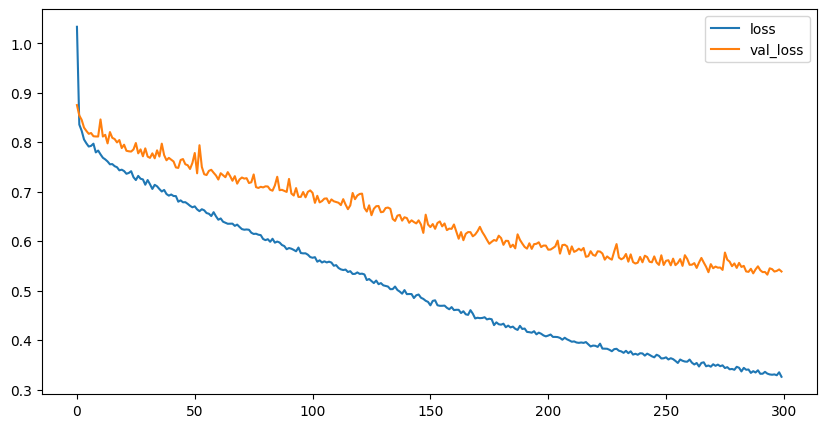

In [121]:
fig, axs = plt.subplots()
fig.set_size_inches(10,5)
axs.plot(history.history['loss'], label="loss")
axs.plot(history.history['val_loss'], label="val_loss")
axs.legend()

2000/2000 [==============================] - 2s 1ms/step
r2:  0.32476200326310034
mae:  0.6248910867849895
mape:  182409811198.11176


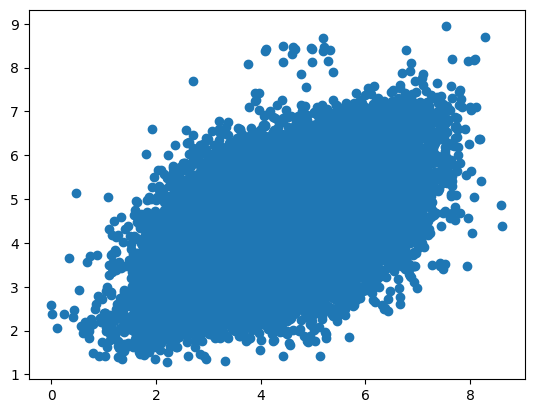

In [122]:
y_pred = model.predict(df.iloc[:,:-1])
y_real = df.iloc[:,-1]
print("r2: ", r2_score(y_real, y_pred))
print("mae: ", mean_absolute_error(y_real, y_pred))
print("mape: ", mean_absolute_percentage_error(y_real, y_pred))
plt.scatter(y_real, y_pred)

In [123]:
df

,x,y,z,litho_Litho_A,litho_Litho_B,litho_Litho_C,alter_Alter_A,alter_Alter_B,alter_Alter_C,alter_Alter_D,finos
0,-1.689278,-1.689278,-1.689278,0,1,0,0,0,1,0,4.692909
1,-1.689278,-1.689278,-1.602648,0,1,0,0,0,0,1,5.276404
2,-1.689278,-1.689278,-1.516018,0,1,0,0,0,0,1,6.127534
3,-1.689278,-1.689278,-1.429389,0,0,1,0,0,0,1,7.067388
4,-1.689278,-1.689278,-1.342759,0,0,1,0,0,0,1,6.976891
...,...,...,...,...,...,...,...,...,...,...,...
63995,1.689278,1.689278,1.342759,0,1,0,0,0,0,1,6.077773
63996,1.689278,1.689278,1.429389,0,1,0,0,0,0,1,5.469884
63997,1.689278,1.689278,1.516018,0,1,0,0,0,1,0,4.591750
63998,1.689278,1.689278,1.602648,0,1,0,0,0,1,0,4.215481
